In [1]:
%matplotlib ipympl

from matplotlib import pyplot as plt
import numpy as np
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
import ipywidgets as widgets

import optitrack.csv_reader as csv
from optitrack.geometry import *

In [2]:
filename = "../material/60fps/skeleton.csv"
# filename = "../material/60fps/rigidbody.csv"

### READ CSV AND LOAD DATA

In [3]:
# Read the file.
take = csv.Take().readCSV(filename)

# Print out some statistics
print("Found rigid bodies:", take.rigid_bodies.keys())

# Process the first rigid body into a set of planes.
bodies = take.rigid_bodies
skeletons = take.skeletons

bones_pos = []
rigid_body_markers_pos = []
markers_pos = []

if len(bodies) > 0:
    for body in bodies: 
        bones = take.rigid_bodies[body]
        n_frames = bones.num_total_frames()
        
        bones_pos.append(bones.positions)
        for marker in bones.rigid_body_markers.values():
            rigid_body_markers_pos.append(marker.positions)
            
        for marker in bones.rigid_body_markers.values():
            markers_pos.append(marker.positions)

if len(skeletons) > 0:
    for body in skeletons: 
        skeleton = take.skeletons[body]
        n_frames = skeleton.bones["Hip"].num_total_frames()
        
        for marker in skeleton.bones.values():
            rigid_body_markers_pos.append(marker.positions)
            
        for marker in skeleton.bone_markers.values():
            markers_pos.append(marker.positions)
        

#points = bones_pos + rigid_body_markers_pos + markers_pos
points = rigid_body_markers_pos

#points = [[0.0,0.0,0.0] if elem is None else elem for elem in markers for markers in points ]
points = [[[0.0, 0.0, 0.0] if frame is None else frame for frame in markers] for markers in points]
np_points = np.array(points)


Found rigid bodies: dict_keys([])


In [4]:
x = np_points[:,:,0]
y = np_points[:,:,1]
z = np_points[:,:,2]

# Extracting x, y, z coordinates
x_coords = np_points[:, :, 0]
y_coords = np_points[:, :, 1]
z_coords = np_points[:, :, 2]

# Define bones dictionary
bones = list(skeleton.bones)
bones_map = {
    "Head": ["Neck"],
    "Neck": ["RShoulder", "LShoulder", "Chest"],
    "RShoulder": ["RUArm"],
    "RUArm": ["RFArm"],
    "RFArm": ["RHand"],
    "RHand": [],
    "LShoulder": ["LUArm"],
    "LUArm": ["LFArm"],
    "LFArm": ["LHand"],
    "LHand": [],
    "Chest": ["Ab"],
    "Ab": ["Hip"],
    "Hip": ["LThigh", "RThigh"],
    "RThigh": ["RShin"],
    "RShin": ["RFoot"],
    "RFoot": ["RToe"],
    "RToe": [],
    "LThigh": ["LShin"],
    "LShin": ["LFoot"],
    "LFoot": ["LToe"],
    "LToe": []
}

# Map bone names to indices
bones_index_map = {bone: bones.index(bone) for bone in bones}

# Map bone indices to their connections
lines_map = {bones_index_map[bone]: [bones_index_map[child] for child in children] for bone, children in bones_map.items()}


### DISPLACE ANIMATION

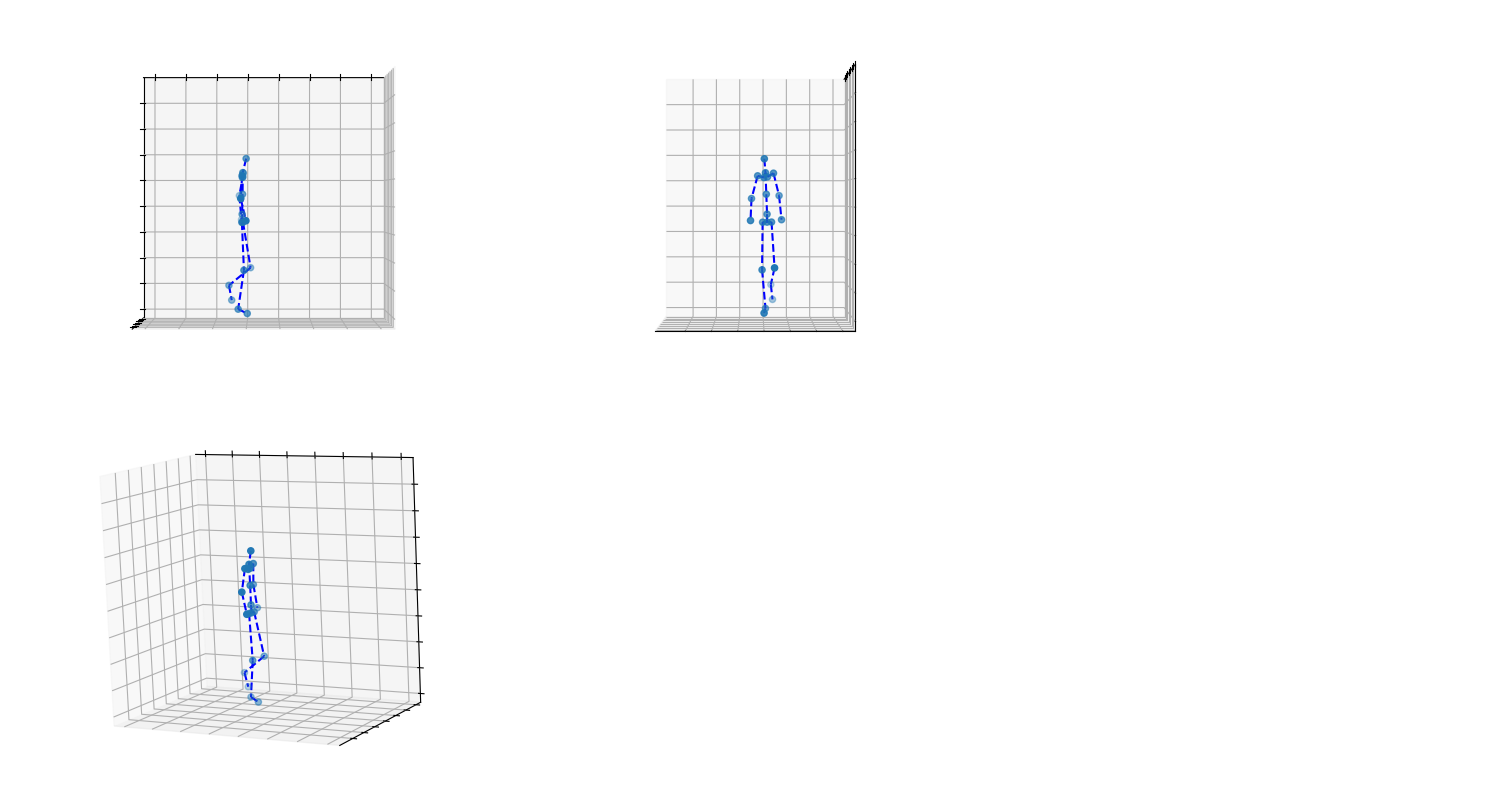

In [5]:
# Create a figure and axes for the plots
fig = plt.figure(figsize=(15, 8))  # Adjust the figure size as needed

# Use GridSpec to customize subplot layout
gs = fig.add_gridspec(2, 3, width_ratios=[1, 1, 1], height_ratios=[1, 1])

# First subplot
ax1 = fig.add_subplot(gs[0, 0], projection='3d')
ax1.view_init(elev=90.001, azim=0, roll=90)  
points1, = ax1.plot([], [], [], "o", color="red")

# Second subplot
ax2 = fig.add_subplot(gs[0, 1], projection='3d')
ax2.view_init(elev=0, azim=0, roll=90)  
points2, = ax2.plot([], [], [], "o", color="red")

# Third subplot
ax3 = fig.add_subplot(gs[1, 0], projection='3d')  # Spanning across the bottom row
ax3.view_init(elev=60, azim=20, roll=110) 
points3, = ax3.plot([], [], [], "o", color="red")

# List containing all the axes
axes = [ax1, ax2, ax3]

# Adjust margins and spacing between subplots
plt.subplots_adjust(left=0.01, right=0.99, bottom=0.01, top=0.99, wspace=0.01, hspace=0.01)

# Define update function
def update(t):
    
    for ax in axes :
        ax.clear()
        ax.set_xlim(np.min(x), np.max(x))
        ax.set_ylim(np.min(y), np.max(y))
        ax.set_zlim(np.min(z), np.max(z))
        ax.scatter(x[:, t], y[:, t], z[:, t])
        ax.tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)
    
    # Plot connections 
    for i in range(len(x[:,t])) :
       for id in lines_map[i] :
           for ax in axes :
               ax.plot([x[i,t], x[id,t]], [y[i,t], y[id,t]]  , [z[i,t], z[id,t]]  , "--", color="blue")

    # Plot trajectories
    trajectory_frames = 180     # displace the previous "trajectory_frames" as an interpolation
    tf = max(0, t-trajectory_frames)
    
    for i in range(len(x)):
        for ax in axes :
            ax.plot(x[i, tf:t], y[i, tf:t], z[i, tf:t], color="red", alpha=0.2)

# Create slider widget
frame_slider = widgets.IntSlider(value=0, min=0, max=n_frames-1, step=1, description='Frame:')

# Define function to update plot when slider changes
def slider_changed(change):
    update(change.new)

# Link slider and update function
frame_slider.observe(slider_changed, 'value')

# Create play button
play_button = widgets.Play(
    value=0,
    min=0,
    max=n_frames-1,
    step=1,
    description="Play",
    interval=1  # Adjust the interval (in milliseconds) as needed
)

# Link play button and slider
widgets.jslink((play_button, 'value'), (frame_slider, 'value'))

# Display play button and slider
display(widgets.HBox([play_button, frame_slider]))

# Initial plot
update(0)

### SAVE THE ANIMATION 

In [6]:
# # Create animation
# anim = animation.FuncAnimation(fig, update, frames=n_frames, interval=100)

# # Save animation as GIF
# anim.save('animations/animation.gif', writer='pillow', fps=60)

In [7]:
from BVH_reader.BVH_FILE import read_bvh

filename = "../material/60fps/animation.bvh"

animation, joint_names, frametime = read_bvh(filename, start=None, end=None, order=None, world=False, need_quater=False)

In [8]:
import c3d

filename = "../material/60fps/marker.c3d"

# Lists to store marker information
frames_data = []
labels = []

reader = c3d.Reader(open(filename, 'rb'))
for i, points, analog in reader.read_frames():
    # Store frame number
    frame_info = {'frame_number': i}
    
    # Store marker coordinates
    marker_info = {}
    for j, label in enumerate(reader.point_labels):
        marker_info[label] = points[j]
    
    frame_info['marker_coordinates'] = marker_info
    
    # Store analog data (if any)
    frame_info['analog_data'] = analog
    
    # Append frame data to the list
    frames_data.append(frame_info)
    
    # Store labels
    if i == 0:  # Assuming labels are same for all frames
        labels = reader.point_labels

# print
#for frame_info in frames_data:
#    frame_number = frame_info['frame_number']
#    marker_coordinates = frame_info['marker_coordinates']
#    analog_data = frame_info['analog_data']
#    
#    print(f"Frame {frame_number}:")
#    
#    # Print marker coordinates
#    for label in labels:
#        coordinates = marker_coordinates[label]
#        print(f"  Marker {label}: {coordinates}")
#    
#    # Print analog data (if any)
#    if analog_data is not None:
#        print("  Analog data:", analog_data)


/home/luca/.local/lib/python3.8/site-packages/c3d/c3d.py:1210: UserWarning: missing parameter POINT:DESCRIPTIONS
  warnings.warn('missing parameter {}'.format(name))
/home/luca/.local/lib/python3.8/site-packages/c3d/c3d.py:1219: UserWarning: No analog data found in file.
  warnings.warn('No analog data found in file.')
/home/luca/.local/lib/python3.8/site-packages/c3d/c3d.py:1774: UserWarning: reached end of file (EOF) while reading POINT data at frame index 12146
                                 and file pointer 7194528!
  warnings.warn('''reached end of file (EOF) while reading POINT data at frame index {}
